In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Dense
import json
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("chat_health.csv")
data = data.head(50)

Normalize the Unicode string to NFD form which decomposes characters

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

clean question and answer

In [ ]:
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + " <eos>"
    return text

In [ ]:
data["short_question"][0]

'is all vitamin d the same'

In [ ]:
data["short_question"] = data.short_question.apply(clean_text)
data["short_question"]

0                 <sos> is all vitamin d the same <eos>
1     <sos> i need relief from chronic epididymitis ...
2             <sos> how is herpes simplex treated <eos>
3                <sos> how do you get hepatitis c <eos>
4       <sos> is cirrhosis a form of liver cancer <eos>
                            ...                        
95                 <sos> can smoking cause asthma <eos>
96              <sos> what causes prostate cancer <eos>
97    <sos> for what purposes are ultrasounds used <...
98                <sos> what is colorectal cancer <eos>
99    <sos> what the best way to cook green beans <eos>
Name: short_question, Length: 100, dtype: object

In [ ]:
data["short_question"][0]

'<sos> is all vitamin d the same <eos>'

In [ ]:
data["short_answer"] = data.short_answer.apply(clean_text)

In [ ]:
question  = data.short_question.values.tolist()
answer =  data.short_answer.values.tolist()

Converts text to sequences, normalizes lengths, retains special characters, for machine learning preprocessing.

In [ ]:
def tokenize(lang):
  # Create a tokenizer object, specifying an empty string for filters to keep all characters
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    # Fit the tokenizer on the provided text data
    lang_tokenizer.fit_on_texts(lang)
    # Convert the text data into sequences of integers
    tensor = lang_tokenizer.texts_to_sequences(lang)
    # Pad the sequences so they all have the same length for model training
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

    return tensor, lang_tokenizer

In [ ]:
input_tensor , inp_lang  =  tokenize(question)

In [ ]:
target_tensor , targ_lang  =  tokenize(answer)

Remove text before <start> and after <end> tag from the sentence

In [ ]:
def remove_tags(sentence):
    return sentence.split("<start>")[-1].split("<end>")[0]

In [ ]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

Model parameter

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12]), TensorShape([64, 62]))

The Encoder class in TensorFlow defines an encoder for seq2seq models, featuring an embedding layer and a GRU layer for processing input sequences and maintaining state across timesteps.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x,hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 12, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


The BahdanauAttention class implements attention mechanism in seq2seq models, calculating context vectors and attention weights using learned transformations of input sequences.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 12, 1)


The Decoder class in TensorFlow decodes sequences using GRU, Bahdanau attention, embedding layers, and a dense output layer for seq2seq models.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1081)


define optimizer and loss function

In [ ]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
import time

EPOCHS = 400

epoch_losses = []
epoch_times = []

EPOCHS = 300
threshold_loss = 0.05

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    epoch_loss = total_loss / steps_per_epoch
    epoch_losses.append(epoch_loss)

    end_time = time.time()
    epoch_times.append(end_time - start_time)

    if epoch % 4 == 0:
        print('Epoch:{:3d} Loss:{:.4f}'.format(epoch, epoch_loss))

    if epoch_loss < threshold_loss:
        print(f'Early stopping at epoch {epoch}: Loss is below the threshold {threshold_loss:.4f}.')
        break


Epoch:  4 Loss:3.4392
Epoch:  8 Loss:3.1204
Epoch: 12 Loss:3.0041
Epoch: 16 Loss:3.1077
Epoch: 20 Loss:3.1214
Epoch: 24 Loss:2.9467
Epoch: 28 Loss:2.8754
Epoch: 32 Loss:2.9427
Epoch: 36 Loss:2.9189
Epoch: 40 Loss:2.8089
Epoch: 44 Loss:2.5790
Epoch: 48 Loss:2.6730
Epoch: 52 Loss:2.5038
Epoch: 56 Loss:2.2182
Epoch: 60 Loss:2.1832
Epoch: 64 Loss:1.8796
Epoch: 68 Loss:1.7585
Epoch: 72 Loss:1.5335
Epoch: 76 Loss:1.4683
Epoch: 80 Loss:1.3447
Epoch: 84 Loss:1.2158
Epoch: 88 Loss:1.0306
Epoch: 92 Loss:0.9566
Epoch: 96 Loss:0.9484
Epoch:100 Loss:0.8260
Epoch:104 Loss:0.7781
Epoch:108 Loss:0.7229
Epoch:112 Loss:0.7116
Epoch:116 Loss:0.6639
Epoch:120 Loss:0.6504
Epoch:124 Loss:0.6224
Epoch:128 Loss:0.5661
Epoch:132 Loss:0.5742
Epoch:136 Loss:0.5407
Epoch:140 Loss:0.5189
Epoch:144 Loss:0.5149
Epoch:148 Loss:0.4943
Epoch:152 Loss:0.4657
Epoch:156 Loss:0.4822
Epoch:160 Loss:0.4537
Epoch:164 Loss:0.4172
Epoch:168 Loss:0.3923
Epoch:172 Loss:0.3745
Epoch:176 Loss:0.3352
Epoch:180 Loss:0.3086
Epoch:184 

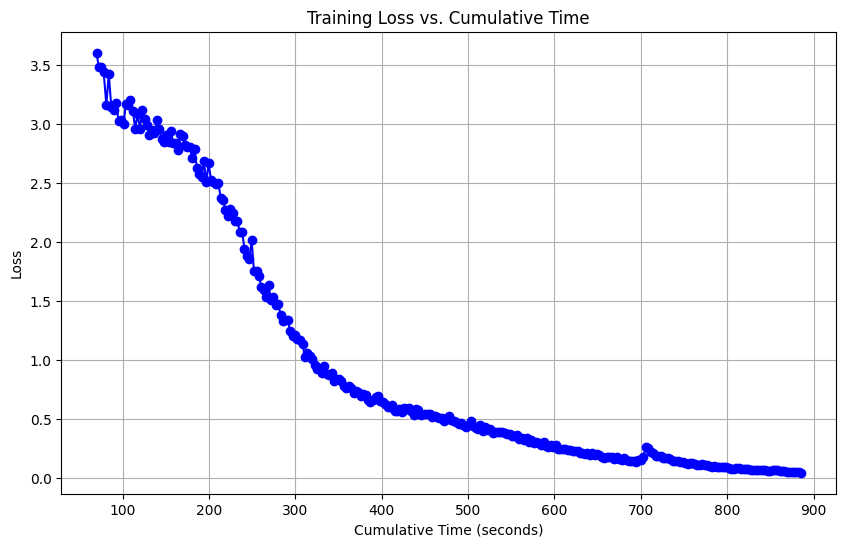

In [ ]:

cumulative_times = [sum(epoch_times[:i+1]) for i in range(len(epoch_times))]


plt.figure(figsize=(10, 6))
plt.plot(cumulative_times, epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss vs. Cumulative Time')
plt.xlabel('Cumulative Time (seconds)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  75008     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
Total params: 4013312 (15.31 MB)
Trainable params: 4013312 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  276736    
                                                                 
 gru_1 (GRU)                 multiple                  7084032   
                                                                 
 d

In [ ]:

encoder.save_weights('encoder_weights.h5')
decoder.save_weights('decoder_weights.h5')


encoder_config = encoder.to_json()
decoder_config = decoder.to_json()

with open('encoder_config.json', 'w') as file:
    file.write(encoder_config)

with open('decoder_config.json', 'w') as file:
    file.write(decoder_config)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json

with open('encoder_config.json', 'r') as file:
    encoder_config = file.read()
print("Encoder JSON Config:", encoder_config)


with open('decoder_config.json', 'r') as file:
    decoder_config = file.read()
print("Decoder JSON Config:", decoder_config)

encoder2 = model_from_json(encoder_config, custom_objects={
    'Encoder': Encoder,
    'GRU': tf.keras.layers.GRU
})

decoder2 = model_from_json(decoder_config, custom_objects={
    'Decoder': Decoder,
    'GRU': tf.keras.layers.GRU,
    'BahdanauAttention': BahdanauAttention
})


print("Type of encoder:", type(encoder2))
print("Type of decoder:", type(decoder2))



Encoder JSON Config: {"class_name": "Encoder", "config": {"vocab_size": 293, "embedding_dim": 256, "enc_units": 1024, "batch_sz": 64}, "keras_version": "2.15.0", "backend": "tensorflow"}
Decoder JSON Config: {"class_name": "Decoder", "config": {"vocab_size": 1081, "embedding_dim": 256, "dec_units": 1024, "batch_sz": 64}, "keras_version": "2.15.0", "backend": "tensorflow"}
Type of encoder: <class '__main__.Encoder'>
Type of decoder: <class '__main__.Decoder'>


In [ ]:

encoder_dummy_input = tf.random.uniform((64, 13), dtype=tf.float32)  # 输入长度为13，批量大小为64
encoder_hidden_initial = encoder2.initialize_hidden_state()
encoder_output, encoder_hidden = encoder2(encoder_dummy_input, encoder_hidden_initial)  # 初始化并构建模型


decoder_dummy_input = tf.random.uniform((64, 1), dtype=tf.float32)  # 每次解码只处理一个时间步长的输入
decoder_output, decoder_hidden, _ = decoder2(decoder_dummy_input, encoder_hidden, encoder_output)  # 构建模型


encoder2.load_weights('encoder_weights.h5')
decoder2.load_weights('decoder_weights.h5')

In [ ]:

print("Encoder Summary:")
encoder2.summary()

print("Decoder Summary:")
decoder2.summary()

Encoder Summary:
Model: "encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  75008     
                                                                 
 gru_2 (GRU)                 multiple                  3938304   
                                                                 
Total params: 4013312 (15.31 MB)
Trainable params: 4013312 (15.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Decoder Summary:
Model: "decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  276736    
                                                                 
 gru_3 (GRU)                 multiple                  7084032   
                              

In [ ]:
def evaluate(sentence):
    sentence = clean_text(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]

    enc_out, enc_hidden = encoder(inputs, hidden,training=False)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out,training=False)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<eos>':
            return remove_tags(result), remove_tags(sentence)

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return remove_tags(result), remove_tags(sentence)

testData =  pd.read_csv("chat_health.csv").head(50)

test_questions  =testData["short_question"]
test_answers = testData["short_answer"]


def generate_answer(sentence):
    result, sentence = evaluate(sentence)
    cleaned_result = result.replace('<eos>', '').strip()
    return cleaned_result

generate_answer(test_questions[3])

'can you get hepitist c from sharing food drinks and smoking after them'

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
testData['generated_answer'] = testData['short_question'].apply(lambda q: generate_answer(q))

references = testData['short_answer'].apply(lambda a: [a.split()]).tolist()
candidates = testData['generated_answer'].apply(lambda a: a.split()).tolist()

bleu_score = corpus_bleu(references, candidates)
print("BLEU Score:", bleu_score)

BLEU Score: 0.5080558214255659


In [ ]:
import time
start_time = time.time()
testData['generated_answer'] = testData['short_question'].apply(lambda q: generate_answer(q))
end_time = time.time()
response_time = end_time - start_time
average_response_time = response_time / 50

print(f"Average response time per record: {average_response_time} seconds")

Average response time per record: 0.6219413709640503 seconds
